# Estimadores baseados em Imputação - *Outcome Regression* (OR)

Prof. Daniel de Abreu Pereira Uhr

## Conteúdo

* Relembrando alguns pontos importantes sobre o estimador OLS
* Introdução aos Estimadores Baseados em Imputação
* Outcome Regression
  * Unilateral
  * Bilateral
* Aplicação no Python
  * EconML


## Referências

* Heckman, James, Hidehiko Ichimura, Jefrey Smith, and Petra Todd. (1998). Characterizing selection bias using experimental data". Econometrica 66.5, pp. 1017-1098.
* Cunningham, S. W. (2013). Causal inference: The mixtape. https://www.scunning.com/mixtape.html
* Courthoud, Matteo. Understanding AIPW. https://matteocourthoud.github.io/post/aipw/ 
* Matheus Facure. Doubly Robust Estimation. https://matheusfacure.github.io/python-causality-handbook/12-Doubly-Robust-Estimation.html
* Pearl, J. (2000). Causality: Models, reasoning, and inference. Cambridge University Press.
* Joshua D. Angrist and Jörn-Steffen Pischke (2009). Mostly Harmless Econometrics: An Empiricist's Companion. Princeton University Press.
* Morgan, S. L., & Winship, C. (2014). Counterfactuals and causal inference: Methods and principles for social research. Cambridge University Press. Capítulo 3.
* EconML Documentation. https://econml.azurewebsites.net/




**Observações:** O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer *feedback* ou sugestão de melhoria.

---

## Relembrando alguns pontos importantes sobre o estimador OLS

Antes de aprofundar a ideia de imputação e ver o estimador de *Outcome Regression* é conveniente relembrar alguns pontos importantes sobre o estimador OLS.

Vimos anteriormente que a **regressão linear** captura a diferença média entre grupos tratados e não tratados de forma equivalente ao *SDO* (*Simple Difference in Outcomes*) quando utilizamos apenas a variável indicadora de tratamento como regressor em um ambiente laboratorial (*Randomized Control Trial - RTC*). Esse resultado decorre do fato de que uma variável dummy $D$ reproduz a diferença de médias entre os dois grupos que compõe a amostra.  

**Conceitos Gerais do OLS**

O **OLS (Ordinary Least Squares)** é um **estimador** para os parâmetros de uma regressão linear. Ele encontra os parâmetros lineares que **minimizam a soma dos quadrados dos resíduos**:

$$
\hat{\beta} = \arg\min_{\beta} \sum_{i=1}^n (Y_i - X_i\beta)^2.
$$

Aplicando o OLS sobre a amostra, obtemos uma **estimativa** $\hat{\beta}$ para o parâmetro populacional $\beta$ (efeito causal do tratamento), representada convencionalmente com um chapéu.


### Modelo Populacional

O modelo teórico assume a seguinte forma:

$$
Y_i = \alpha + \beta D_i + \theta X_i + u_i,
$$

onde:  
- $D_i$ é a variável de tratamento (dummy);  
- $X_i$ é o vetor de covariáveis;  
- $u_i$ é o erro aleatório.  

As hipóteses clássicas necessárias para identificação e inferência são:  

1. **Linearidade**: o modelo é linear nos parâmetros;  
2. **Exogeneidade**: $\mathbb{E}[u_i|X_i,D_i] = 0$;  
3. **Não-multicolinearidade**: $X_i$ e $D_i$ não são linearmente dependentes;  
4. **Homoscedasticidade**: $\operatorname{Var}(u_i|X_i,D_i) = \sigma^2$;  
5. **Normalidade dos erros** (opcional em grandes amostras, mas relevante em amostras pequenas).  

- As três primeiras hipóteses são fundamentais para **identificação** do parâmetro causal.  
- As duas últimas são importantes para **inferência estatística** (intervalos de confiança e testes).  


### Propriedades do Estimador OLS

- **Não-viesado**: em amostras finitas, $\mathbb{E}[\hat{\beta}] = \beta$, sob as hipóteses de exogeneidade.  
- **Consistência**: à medida que $n \to \infty$, $\hat{\beta} \xrightarrow{p} \beta$.  
- **Eficiência (Gauss–Markov)**: o OLS tem a menor variância entre todos os estimadores lineares não-viesados (BLUE).  


### Inferência com OLS

Após obter a estimativa pontual $\hat{\beta}$, precisamos ***quantificar sua incerteza***. O erro padrão do OLS decorre da variância assintótica do estimador (pelo Teorema Central do Limite):

$$
\sqrt{n}(\hat{\beta} - \beta) \xrightarrow{d} \mathcal{N}(0, \, \sigma^2 (X'X)^{-1}),
$$

derivada a partir da matriz de variância do OLS. 

Assim, o erro padrão é:

$$
\widehat{se}(\hat{\beta}) = \sqrt{\widehat{\sigma}^2 \cdot ((X'X)^{-1})_{jj}},
$$

Ou seja:

$$ \widehat{se}(\hat{\theta}) = \sqrt{\frac{\frac{\sum \hat{u}_{i}^{2}}{n-k}}{\frac{\sum (x_{i} - \bar{x})^{2}}{n}}} = \frac{\widehat{\sigma}}{\sqrt{n.\hat{var}(x)}} = \frac{1}{\sqrt{n}}\frac{\widehat{\sigma}}{\sqrt{\hat{var}(x)}} $$

Repare:
* o numerador é o desvio padrão dos resíduos $\widehat{\sigma}$, irá convergir para $\sigma$ quando $n$ crescer.
* o denominador envolve a variabilidade de $x$, que cresce linearmente com $n$.
* juntos, mostram claramente que o erro padrão cai a uma taxa de $1/\sqrt{n}$.


**Ingredientes para inferência**
* Estimativa pontual,
* Erro padrão (analítico), e
* uma medida de incerteza (grau de tolerância ao risco de erro na inferência: $\alpha$ - erro tipo I)
  * De outra perspectiva, ($1-\alpha$) é o nível de confiança assumido.


**Fórmula dos intervalos de confiança**

construímos o intervalos de confiança para a estimativa:  

- Para grandes amostras (normalidade assintótica, normal padrão):  

$$
IC_{1-\alpha}(\beta) = \hat{\beta} \pm z_{1-\alpha/2}\,\widehat{se}(\hat{\beta}),
$$  

- Para pequenas amostras (usando distribuição $t$ de Student com $n-k$ graus de liberdade):  

$$
IC_{1-\alpha}(\beta) = \hat{\beta} \pm t_{n-k,1-\alpha/2}\,\widehat{se}(\hat{\beta}).
$$  


Lembre que o centro do intervalo é sempre a estimativa pontual.

A largura do intervalo depende de:
* O erro padrão (quanto menor, mais preciso o intervalo).
* O valor crítico (que depende de $\alpha$ e da distribuição escolhida).
* Por isso, se aumentamos a amostra ($n$ maior), o erro padrão cai e o intervalo de confiança fica mais estreito.

**Diferentes práticas de construção de IC**

Costuma-se classificar a inferência em:

* ***Inferência Analítica / Assintótica***
  * Clássico (homoscedástico): como visto anteriormente
  * Robusto (heteroscedástico/cluster):
    * White, Eicker–Huber–White, cluster-robust (corrigem para heteroscedasticidade e dependência).
  * Método delta: para funções não lineares de estimadores ($g(\hat{\beta})$, como $e^{\hat{\beta}}$).
    * Probit, logit, etc.
    * usa uma expansão de Taylor de primeira ordem para aproximar a variância de $g(\hat{\beta})$.
  * Assintótico geral: baseados no TCL vetorial → válidos em grandes amostras.
  * ***Vantagens: rápidos, fáceis, matematicamente elegantes.***
  * ***Limites: dependem muito de pressupostos (ex.: robustos corrigem parte, mas ainda assumem grandes amostras).***

* **Inferência Numérica / Computacional**
  * Bootstrap
    * Reamostragem dos dados.
    * Recalcula $\hat{\beta}^*$ várias vezes → obtém distribuição empírica.
    * IC = quantis da distribuição empírica.
    * Muito usado quando erros padrão analíticos são complicados ou amostras pequenas.
  * Jackknife
    * Versão “leave-one-out”: retira observações, reestima, mede variação.
    * Boa para pequenas amostras e casos de influência de pontos individuais.
  * Monte Carlo / Simulação ou "laboratório estatístico"
    * Em contextos experimentais ou modelos bem especificados, simulamos dados sob o modelo para obter a distribuição do estimador.
    * Útil em pesquisa aplicada quando queremos verificar a performance do estimador em cenários controlados.
  * Vantagens: flexíveis, poucos pressupostos.
  * Limites: demandam mais custo computacional e escolhas (número de replicações, esquema de reamostragem).



## Introdução aos Estimadores Baseados em Imputação


***Contexto***


Na prática, grande parte dos estimadores para identificação causal buscam lidar com essa de dados ou informações não observadas, preenchendo esses valores faltantes com estimativas calculadas a partir dos dados disponíveis e/ou "previsões" para eles.

Considerando o exemplo anterior:

| Unidade |   $Y^{1}$     |  $Y^{0}$     | $D$      |  $X $    |
|---------|--------|-------|--------|-------|
| 1       | 5      |   ?    | 1      | 11    |
| 2       | 2      |   ?    | 1      | 7     |
| 3       | 10     |   ?    | 1      | 5     |
| 4       | 6      |   ?    | 1      | 3     |
| 5       |   ?     | 4     | 0      | 10    |
| 6       |   ?     | 0     | 0      | 8     |
| 7       |   ?     | 5     | 0      | 4     |
| 8       |   ?     | 1     | 0      |  1    |


Normalmente, temos a disposição outras variáveis (covariáveis) que caracterizam os indivíduos e a relação causal (como vimos nas aulas anteriores). Na tabela anterior, representamos como $X$.

Naturalmente, se $X$ é uma covariável relevante (possivel confundidora, em que sua omissão gera viés por omissão - OBV), a primeira estratégia que vem a nossa mente é controlá-la na regressão linear:

$$ Y = \alpha + \tau D + \gamma X + \epsilon $$


Continuamos considerando $ Y $ como a variável dependente, $ D $ é a variável indicadora de tratamento (1 se o tratamento foi aplicado, 0 caso contrário), $ X $ são as covariáveis observáveis, e $ \epsilon $ é o termo de erro do modelo.

Agora, repare que se aplicamos a expectativa condicional de $Y$ em $D$, temos:

$$ E[Y|X, D=1] = \alpha + \tau (1) + \gamma_{1} (X) +  u_1  $$

$$ E[Y|X, D=0] = \alpha + \tau (0) + \gamma_{0} (X) + u_0  $$


***Generalizando a relação***

Repare poderiamos chamar a média para os tratados de $\mu_{1}$ e para os não tratados de $\mu_{0}$:

$$ E[Y|X, D=1] = \alpha + \tau (1) + \gamma_{1} (X) +  u_1  = \mu_{1}(X) + u_1 $$

$$ E[Y|X, D=0] = \alpha + \tau (0) + \gamma_{0} (X) + u_0  = \mu_{0}(X) + u_0$$

Então, $\mu_{1}(X) $ e $ \mu_{0}(X) $ representam as **médias dos resultados potenciais** para os tratados e não tratados, respectivamente, ***dados $ X $*** (Condicional a $X$ também!). Os termos $ u_1 $ e $u_0 $ são termos de erro associados aos grupos de tratamento e controle, respectivamente (termos de erros nas sub-amostras/ sub-grupos).

Uma vantagem de representar os grupos dessa forma é que podemos entender que eles podem apresentar relações distintas entre eles. Ou seja, podemos generalizar a relação para modelos não lineares. E, fica evidenciada a sua dependência das características $X$.
   

### *Outcome Regression - OR*

O *Outcome Regression* ou "regressão de variável de resultado" utiliza o arcabouço que definimos anteriormente para resolver o problema de imputação dos dados. Vejamos detalhadamente.

Noso ponto de partida é estimar o efeito causal. O principal efeito a ser estimado é o *Average Treatment Effect - ATE*. Vimos que o ATE é definido como:

$$ATE = E[\tau_{i}] = E[Y_{i}^{1} - Y_{i}^{0}]$$

Devido à falta de observação simultânea de $Y^{1}$ e $Y^{0}$ para a mesma unidade, os pesquisadores propuseram o Outcome Regression, que é um  **estimador baseado em imputação** para estimar o potencial resultado não observado.

A ideia é que podemos estimar o ATE a partir de **valores previstos** dos resultados potenciais de tratamento ($\hat{Y^{1}}$) e de não-tratado ($\hat{Y^{0}}$).

Como visto anteriormente, rodar um modelo para estimar $\mu_{1}(X) $ e $ \mu_{0}(X) $ e utilizar esses valores previstos como resultados potenciais para imputar os dados faltantes.

**Exemplo aplicado em python**

In [1]:
# bibliotecas
import pandas as pd
import statsmodels.formula.api as smf 

In [8]:
# Carregar DataFrame
df = pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/training_bias_reduction.dta")

In [9]:
# Ver os dados carregados
df

,Unit,Y,D,X
0,1,5,1,11
1,2,2,1,7
2,3,10,1,5
3,4,6,1,3
4,5,4,0,10
5,6,0,0,8
6,7,5,0,4
7,8,1,0,1


Vamos rodar a regressão entre $Y$ e $X$, para os tratados ($D=1$, condicionado nessa subamostra). Aqui estamos estimando a função $\mu_1 (.)$.

In [10]:
reg1 = smf.ols('Y ~ X', data=df[df['D'] == 1]).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                 -0.296
Method:                 Least Squares   F-statistic:                    0.3157
Date:                qua, 20 ago 2025   Prob (F-statistic):              0.631
Time:                        16:44:18   Log-Likelihood:                -9.5879
No. Observations:                   4   AIC:                             23.18
Df Residuals:                       2   BIC:                             21.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0714      4.540      1.778      0.2

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Então, estamos dizendo que os resultados (Y) dos tratados são modelados da seguinte forma:

$$ Y = 8.07 - 0.3571 X $$

Agora, vamos adicionar ao nosso dataframe uma coluna para os valores médios de $Y$ previstos considerando $\mu_{1}$.

In [11]:
df['mu_1']= reg1.predict(df)

In [12]:
df

,Unit,Y,D,X,mu_1
0,1,5,1,11,4.142857
1,2,2,1,7,5.571429
2,3,10,1,5,6.285714
3,4,6,1,3,7.000000
4,5,4,0,10,4.500000
5,6,0,0,8,5.214286
6,7,5,0,4,6.642857
7,8,1,0,1,7.714286


O que ocorreu aqui é que estimamos $\mu_{1}(.)$ na subamostra dos tratados, e aplicamos os valores de $X$ e obtivemos os valores previstos respectivos para $Y$ para todos os *i*. Repare que para o caso dos não tratados, imputamos resultados "caso eles fossem tratados" (contrafactual para os não tratados!).

Vamos fazer o mesmo para o grupo de não tratados.

In [13]:
reg0 = smf.ols('Y ~ X', data=df[df['D'] == 0]).fit()
print(reg0.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.478
Method:                 Least Squares   F-statistic:                   0.03001
Date:                qua, 20 ago 2025   Prob (F-statistic):              0.878
Time:                        16:44:24   Log-Likelihood:                -8.5398
No. Observations:                   4   AIC:                             21.08
Df Residuals:                       2   BIC:                             19.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0872      2.788      0.749      0.5

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Aqui a relação é diferente:

$$ Y = 2.0872 + 0.0718 $$

Vamos salvar os valores preditos.

In [14]:
df['mu_0']= reg0.predict(df)

In [15]:
df

,Unit,Y,D,X,mu_1,mu_0
0,1,5,1,11,4.142857,2.876923
1,2,2,1,7,5.571429,2.589744
2,3,10,1,5,6.285714,2.446154
3,4,6,1,3,7.000000,2.302564
4,5,4,0,10,4.500000,2.805128
5,6,0,0,8,5.214286,2.661538
6,7,5,0,4,6.642857,2.374359
7,8,1,0,1,7.714286,2.158974


O que fizemos aqui foi modelar a relação entre $Y$ e $X$ para o grupo de controle de forma linear. Identificado os parâmetros dessa relação, pegamos os valores previstos para todos os indivíduos *i*, tanto os não tratados, quanto os tratados. Para os tratados, esses valores representam o seu contrafactual.

Essa abordagem recebe o nome de ***imputação dupla*** (ou bilateral).

Agora podemos calcular o efeito médio do tratamento (ATE) nos valores previstos de $\hat{Y}^{1}$ ($\hat{\mu}_{1}$) e $\hat{Y}^{0}$ ($\hat{\mu}_{0}$), e então estimar o efeito médio do tratamento.


$$ATE = E[\tau_{i}] = E[Y_{i}^{1} - Y_{i}^{0}]$$

ou seja,

$$ \hat{ATE} = \frac{1}{N} \sum_{i=1}^{N} \left( \hat{Y}_{i}^{1} - \hat{Y}_{i}^{0} \right) =  \frac{1}{N} \sum_{i=1}^{N} \left( \hat{\mu}_{i}^{1} - \hat{\mu}_{i}^{0} \right) $$


In [16]:
# adicionando a coluna com o valor ITE previsto (tau_previsto)
df['tau_previsto'] = df['mu_1'] - df['mu_0']

In [17]:
# Ver o dataframe
df

,Unit,Y,D,X,mu_1,mu_0,tau_previsto
0,1,5,1,11,4.142857,2.876923,1.265934
1,2,2,1,7,5.571429,2.589744,2.981685
2,3,10,1,5,6.285714,2.446154,3.839560
3,4,6,1,3,7.000000,2.302564,4.697436
4,5,4,0,10,4.500000,2.805128,1.694872
5,6,0,0,8,5.214286,2.661538,2.552747
6,7,5,0,4,6.642857,2.374359,4.268498
7,8,1,0,1,7.714286,2.158974,5.555311


Bem, para calcular o ATE, pelo método de Outcome Regression basta fazer a média dos ITE encontrados.

In [18]:
ATE = df['tau_previsto'].mean()
print(f"\nEfeito Médio do Tratamento (ATE) estimado: {ATE}")


Efeito Médio do Tratamento (ATE) estimado: 3.3570054945054957


**E o ATT e o ATC?**

Podemos também estimar o efeito médio do tratamento para os tratados (ATT) e o efeito médio do tratamento para os não tratados (ATU), que são definidos como:

$$ATT = E[Y_{i}^{1} - Y_{i}^{0} | D = 1]$$

$$ATU = E[Y_{i}^{1} - Y_{i}^{0} | D = 0]$$



In [19]:
# Calculando o ATT (média dos tau_previsto para D=1)
ATT = df[df['D'] == 1]['tau_previsto'].mean()

# Calculando o ATU (média dos tau_previsto para D=0)
ATU = df[df['D'] == 0]['tau_previsto'].mean()

In [20]:
# Exibindo os resultados
print(f"Efeito Médio do Tratamento (ATE): {ATE}")
print(f"Efeito Médio do Tratamento sobre os Tratados (ATT): {ATT}")
print(f"Efeito Médio do Tratamento sobre os Não-Tratados (ATU): {ATU}")

Efeito Médio do Tratamento (ATE): 3.3570054945054957
Efeito Médio do Tratamento sobre os Tratados (ATT): 3.1961538461538472
Efeito Médio do Tratamento sobre os Não-Tratados (ATU): 3.517857142857144


**Interpretação dos Resultados**

* **ATE (Efeito Médio do Tratamento):** Estimado em aproximadamente 3.36, indica o efeito médio esperado do tratamento na população geral.

* **ATT (Efeito Médio sobre os Tratados):** Estimado em aproximadamente 3.20, sugere que, para as unidades que receberam o tratamento, o efeito médio do tratamento é um aumento de 3.20 unidades em Y, comparado com elas mesmo caso não tivessem sido tratadas (contrafactual).

* **ATU (Efeito Médio sobre os Não-Tratados)**: Estimado em aproximadamente 3.52, indica que, se as unidades não tratadas tivessem recebido o tratamento, o efeito médio esperado seria um aumento de 3.52 unidades em Y.

***Outcome regression com imputação unilateral***

Mas poderíamos imputar apenas os dados faltantes? A resposta é sim.

Nós queremos:
* ATT (OR unilateral para os tratados): queremos manter os valores reais de Y para os tratados, e imputar o seu contrafactual $Y^{0}$.
* ATU (OR unilateral para os não-tratados): queremos manter os valores reais de Y para os não tratados, e imputar o seu contrafactual $Y^{1}$.

Para encontrar o ATE, devemos considerar:

$$ ATE = \phi ATT + (1-\phi)ATU $$


para aplicar a ideia unilateral, no caso do exemplo aplicado em python.

**ATT (unilateral para tratados)**  

Repare que aqui consideramos os valores observados de *i* contra a previsão do seu contrafactual.

$$ \hat{ATT} = \frac{1}{4} \sum_{i:D=1} (Y_i - \widehat{Y}^0_i) $$

- Unidade 1: $11 - 2.876923 = 8.123077$  
- Unidade 2: $7 - 2.589744 = 4.410256$  
- Unidade 3: $5 - 2.446154 = 2.553846$  
- Unidade 4: $3 - 2.302564 = 0.697436$  

Soma = $15.784615$; 

Média = **3.946154**

**ATU (unilateral para os não-tratados)**  

Aqui, de forma semelhante, consideramos os valores observados dos não tratados contra seu contrafactual.


$$ \hat{ATU} = \frac{1}{4} \sum_{i:D=0} (\widehat{Y}^1_i - Y_i) $$

- Unidade 5: $4.5 - 10 = -5.5$
- Unidade 6: $5.214286 - 8 = -2.785714$
- Unidade 7: $6.642857 - 4 = 2.642857$  
- Unidade 8: $7.714286 - 1 = 6.714286$  

Soma = $1.071429$. 

Média = **0.267857**.


**ATE via combinação**  

Como sabemos, o ATE é calculado pela média ponderada entre ATT e ATU. Com a proporção tratados dada por $\phi = 4/8 = 0.5$:  


$$ \hat{ATE} = (0.5) \cdot 3.946154 + (0.5) \cdot 0.267857 $$

$\hat{ATE} = 2.1070055$

Em comparação com o **ATE via dupla imputação** (DI) feito anteriormente:

$$ \hat{ATE}_{DI} = \frac{1}{8} \sum_{i=1}^8 (\widehat{Y}^1_i - \widehat{Y}^0_i) = 3.3570056$$

Os dois valores não coincidem aqui porque estamos em amostra finita e cada método está usando modelos diferentes para prever $Y^1$ e $Y^0$ (um unilateral para cada grupo, outro bilateral para todos). Teoricamente, se os modelos fossem as verdadeiras médias condicionais, eles coincidiriam.


### Aplicação no Python

Vamos fazer um exemplo prático no Python, com os dados das mães fumantes e não fumantes durante a gestação, e o peso dos bebês ao nascer. 

Vamos fazer:
* a análise bilateral, e 
* a análise unilateral.

e verificar se os resultados se equivalem.


Pacotes necessários:

In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

Carregando os dados de peso dos bebês ao nascer:

In [22]:
# DataFrame "data"
data = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/cattaneo2.dta")

In [23]:
data

,bweight,mmarried,mhisp,fhisp,foreign,alcohol,deadkids,mage,medu,fage,...,order,msmoke,mbsmoke,mrace,frace,prenatal,birthmonth,lbweight,fbaby,prenatal1
0,3459,married,0,0,0,0,0,24,14,28,...,2,0 daily,nonsmoker,1,1,1,12,0,No,Yes
1,3260,notmarried,0,0,1,0,0,20,10,0,...,3,0 daily,nonsmoker,0,0,1,7,0,No,Yes
2,3572,married,0,0,1,0,0,22,9,30,...,3,0 daily,nonsmoker,1,1,1,3,0,No,Yes
3,2948,married,0,0,0,0,0,26,12,30,...,2,0 daily,nonsmoker,1,1,1,1,0,No,Yes
4,2410,married,0,0,0,0,0,20,12,21,...,1,0 daily,nonsmoker,1,1,1,3,1,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4637,3317,notmarried,0,0,0,0,0,21,12,24,...,1,1-5 daily,smoker,1,1,2,10,0,Yes,No
4638,3030,married,0,0,0,1,1,30,12,23,...,2,11+ daily,smoker,1,1,2,2,0,No,No
4639,2950,notmarried,0,0,0,0,0,23,12,0,...,1,0 daily,nonsmoker,0,0,1,5,0,Yes,Yes
4640,3969,married,0,0,0,0,0,23,12,25,...,1,0 daily,nonsmoker,1,1,1,2,0,Yes,Yes


In [24]:
#Filtragem dos dados

# Criar a variável de resultado
data['Y'] = data['bweight']

# Crie a variável 'D' ("Treated" ou tratado) com valor inicial de 0
data['D'] = 0
# Recodifique 'D' para 1 se 'mbsmoke' for igual a 'smoker'
data.loc[data['mbsmoke'] == 'smoker', 'D'] = 1

# Criar variáveis de controle
data['Mmarried'] = 0
data.loc[data['mmarried'] == 'married', 'Mmarried'] = 1
data['casada'] = 0
data.loc[data['mmarried']=='married', 'casada'] = 1

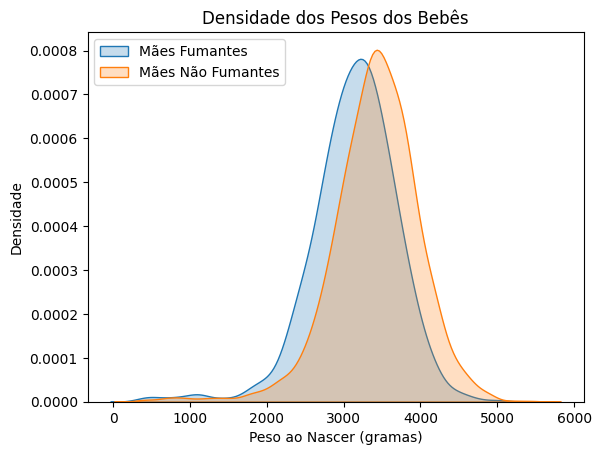

In [48]:
# Visualizando as densidades dos pesos dos bebês entre mães fumantes e não fumantes
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data=data[data['D'] == 1]['Y'], label='Mães Fumantes', fill=True)
sns.kdeplot(data=data[data['D'] == 0]['Y'], label='Mães Não Fumantes', fill=True)
plt.title('Densidade dos Pesos dos Bebês')
plt.xlabel('Peso ao Nascer (gramas)')
plt.ylabel('Densidade')
plt.legend()
plt.show()

***OR Bilateral***

Vamos considerar que:
* o peso dos bebes é nossa variável de resultado ($Y$); 
* o tratamento é se a gestante fumou durante a gravidez ($D$). 
* E as possiveis covariáveis $X$ são: "casada", "mage" e "medu" , "fage", "fedu", "nprenatal", (título de exemplo).

vejamos essas variáveis especificas:

In [25]:
data[['Y', 'D', 'casada', 'mage', 'medu', 'fage', 'fedu', 'nprenatal']]

,Y,D,casada,mage,medu,fage,fedu,nprenatal
0,3459,0,1,24,14,28,16,10
1,3260,0,0,20,10,0,0,6
2,3572,0,1,22,9,30,9,10
3,2948,0,1,26,12,30,12,10
4,2410,0,1,20,12,21,14,12
...,...,...,...,...,...,...,...,...
4637,3317,1,0,21,12,24,12,10
4638,3030,1,1,30,12,23,12,9
4639,2950,0,0,23,12,0,12,12
4640,3969,0,1,23,12,25,12,12


Conforme fizemos anteriormente, realizamos a regressão para os tratados, e salvamos os resultados na variável `reg_1`.

In [26]:
reg_1 = smf.ols('Y ~ casada + medu + mage + fage + fedu + nprenatal', data=data[data['D'] == 1]).fit()
print(reg_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     6.496
Date:                qua, 20 ago 2025   Prob (F-statistic):           1.03e-06
Time:                        16:44:59   Log-Likelihood:                -6675.0
No. Observations:                 864   AIC:                         1.336e+04
Df Residuals:                     857   BIC:                         1.340e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3058.7740    127.002     24.085      0.0

Vamos colocar os valores previstos pela regressão numa nova coluna chamada `Y_imput_1`.

In [27]:
data['Y_imput_1'] = reg_1.predict(data)

Vejamos o que temos agora:

In [28]:
data[['Y', 'Y_imput_1', 'D', 'casada', 'mage', 'medu', 'fage', 'fedu', 'nprenatal']]

,Y,Y_imput_1,D,casada,mage,medu,fage,fedu,nprenatal
0,3459,3218.452786,0,1,24,14,28,16,10
1,3260,3042.624256,0,0,20,10,0,0,6
2,3572,3203.446429,0,1,22,9,30,9,10
3,2948,3183.066766,0,1,26,12,30,12,10
4,2410,3294.984509,0,1,20,12,21,14,12
...,...,...,...,...,...,...,...,...,...
4637,3317,3138.828560,1,0,21,12,24,12,10
4638,3030,3129.148073,1,1,30,12,23,12,9
4639,2950,3184.391476,0,0,23,12,0,12,12
4640,3969,3259.766916,0,1,23,12,25,12,12


Agora fazemos o mesmo para os não tratados.

In [29]:
reg_2 = smf.ols('Y ~ casada + medu + mage + fage + fedu + nprenatal', data=data[data['D'] == 0]).fit()
print(reg_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     42.07
Date:                qua, 20 ago 2025   Prob (F-statistic):           6.20e-50
Time:                        16:45:06   Log-Likelihood:                -29216.
No. Observations:                3778   AIC:                         5.845e+04
Df Residuals:                    3771   BIC:                         5.849e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2883.4617     57.843     49.850      0.0

In [30]:
data['Y_imput_0'] = reg_2.predict(data)

In [31]:
data[['Y', 'Y_imput_1', 'Y_imput_0', 'D', 'casada', 'mage', 'medu', 'fage', 'fedu', 'nprenatal']]

,Y,Y_imput_1,Y_imput_0,D,casada,mage,medu,fage,fedu,nprenatal
0,3459,3218.452786,3399.612463,0,1,24,14,28,16,10
1,3260,3042.624256,3148.347135,0,0,20,10,0,0,6
2,3572,3203.446429,3393.614429,0,1,22,9,30,9,10
3,2948,3183.066766,3408.323735,0,1,26,12,30,12,10
4,2410,3294.984509,3453.453898,0,1,20,12,21,14,12
...,...,...,...,...,...,...,...,...,...,...
4637,3317,3138.828560,3267.464597,1,0,21,12,24,12,10
4638,3030,3129.148073,3400.404614,1,1,30,12,23,12,9
4639,2950,3184.391476,3360.226369,0,0,23,12,0,12,12
4640,3969,3259.766916,3462.623742,0,1,23,12,25,12,12


Como temos os dois possíveis "estados da natureza" imputados, medidos pelos valores `Y_imput_1` e `Y_imput_0`, podemos calcular o ATE como a média dos ITEs.

In [32]:
# adicionando a coluna com o valor ITE previsto para DUPLA IMPUTAÇÃO
data['ITE_OR_DImput'] = data['Y_imput_1'] - data['Y_imput_0']

In [33]:
data[['Y', 'Y_imput_1', 'Y_imput_0', 'ITE_OR_DImput', 'D', 'casada', 'mage', 'medu', 'fage', 'fedu', 'nprenatal']]

,Y,Y_imput_1,Y_imput_0,ITE_OR_DImput,D,casada,mage,medu,fage,fedu,nprenatal
0,3459,3218.452786,3399.612463,-181.159678,0,1,24,14,28,16,10
1,3260,3042.624256,3148.347135,-105.722879,0,0,20,10,0,0,6
2,3572,3203.446429,3393.614429,-190.168001,0,1,22,9,30,9,10
3,2948,3183.066766,3408.323735,-225.256969,0,1,26,12,30,12,10
4,2410,3294.984509,3453.453898,-158.469389,0,1,20,12,21,14,12
...,...,...,...,...,...,...,...,...,...,...,...
4637,3317,3138.828560,3267.464597,-128.636037,1,0,21,12,24,12,10
4638,3030,3129.148073,3400.404614,-271.256541,1,1,30,12,23,12,9
4639,2950,3184.391476,3360.226369,-175.834893,0,0,23,12,0,12,12
4640,3969,3259.766916,3462.623742,-202.856825,0,1,23,12,25,12,12


O ATE será:

In [34]:
ATE_OR_bilateral = data['ITE_OR_DImput'].mean()
ATE_OR_bilateral

-227.12758124161465

E se quisermos o ATT e o ATU?


Para o ATT, basta realizarmos a média no subgrupo dos tratados.

In [35]:
# Calculando o ATT (média dos tau_previsto para D=1)
ATT_OR_bilateral = data[data['D'] == 1]['ITE_OR_DImput'].mean()
ATT_OR_bilateral

-201.84038749392622

Para o ATU, basta realizarmos a média no subgrupo dos não tratados.

In [36]:
# Calculando o ATU (média dos tau_previsto para D=0)
ATU_OR_bilateral = data[data['D'] == 0]['ITE_OR_DImput'].mean()
ATU_OR_bilateral

-232.91057102404

***OR Unilateral***

Certo, agora queremos verificar se fazendo o OR unilateral chegamos a um resultado semelhante. Entretanto, agora vamos considerar os valores observados de $Y$ para os tratados, contra os valores imputados do contrafactual $Y^{0}$. Em termos de equação:


$$ \hat{ATT} = \frac{1}{n} \sum_{i:D=1} (Y_i - \widehat{Y}^0_i) $$


In [37]:
ATT_OR_unilateral = (data.loc[data['D'] == 1, 'Y'] - data.loc[data['D'] == 1, 'Y_imput_0']).mean()
ATT_OR_unilateral

-201.8403874939284

para o ATU:


$$ \hat{ATU} = \frac{1}{n} \sum_{i:D=0} (\widehat{Y}^1_i - Y_i) $$


In [38]:
ATU_OR_unilateral = (data.loc[data['D'] == 0, 'Y_imput_1'] - data.loc[data['D'] == 0, 'Y']).mean()
ATU_OR_unilateral

-232.91057102404469

Para fechar e identificarmos o ATE, vamos fazer a média ponderada.

In [39]:
# Proporção de tratados
p = data['D'].mean()  # média de D = proporção de 1's
p

0.18612666953899182

In [40]:
# ATE como combinação ponderada
ATE_from_unilateral = p * ATT_OR_unilateral + (1 - p) * ATU_OR_unilateral

ATE_from_unilateral

-227.1275812416189

Nesse exemplo vimos que os resultados encontrados são muito semelhantes entre o OR unilateral e o bilateral, conforme esperado.

* ATE Bilaterial: $-227.12758124161465$
* ATE Unilateral: $-227.1275812416189$

* ATT Bilateral: $-201.84038749392622$
* ATT Unilateral: $-201.8403874939284$


Encontramos estimativas pontuais para o ATE, ATT e ATU, que são muito próximas entre os métodos bilateral e unilateral. Entretanto, para realizar inferência causal, precisaríamos calcular os erros padrão e construir intervalos de confiança.

***Inferência Causal***

Sabemos que a amostra que possuímos é apenas uma parte da população, e que a inferência causal é sempre feita para a população. Por isso, precisamos construir intervalos de confiança em torno das nossas estimativas do efeito. Essa etapa é essencial, pois nos permite:

* Quantificar a incerteza amostral associada ao efeito causal;
* Realizar testes de hipóteses sobre a significância estatística do efeito.

Vamos aplicar a biblioteca "EconML" para identificar o efeito e calcular os intervalos de confiança associados. Para realizar o Outcome regression com essa biblioteca, utilizamos o chamado "T-learner". Ele realiza exatamente o procedimento que vimos anteriormente, além de calcular os intervalos de confiança através de bootstrap.


In [41]:
import numpy as np
import warnings
warnings.filterwarnings("ignore", message="\'force_all_finite\' was renamed to \'ensure_all_finite\'")

from sklearn.linear_model import LinearRegression
from econml.metalearners import TLearner
from econml.inference import BootstrapInference

In [42]:
# Fixar semente global (para reprodutibilidade)
np.random.seed(42)

X = data[['casada', 'mage', 'medu', 'fage', 'fedu', 'nprenatal']].values
Y = data['Y'].values
T = data['D'].values.astype(int)

t_learner = TLearner(models=LinearRegression())
t_learner.fit(
    Y=Y, T=T, X=X,
    inference=BootstrapInference(
        n_bootstrap_samples=1000,
        n_jobs=-1,
        bootstrap_type="normal",
    )
)

In [ ]:
# ATE
ate_res   = t_learner.ate_inference(X=X, T0=0, T1=1)
ate_res.summary().tables[0]


mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
-227.128,56.04,-4.053,0.0,-336.963,-117.292


In [44]:
# ATT
X_t = X[T == 1]
att_res   = t_learner.ate_inference(X=X_t, T0=0, T1=1)
att_res.summary().tables[0]


mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
-201.84,59.762,-3.377,0.001,-318.971,-84.709


In [45]:
# ATU
X_c = X[T == 0]
atu_res   = t_learner.ate_inference(X=X_c, T0=0, T1=1)
atu_res.summary().tables[0]

mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
-232.911,55.153,-4.223,0.0,-341.009,-124.813


padrão do EconML é 95% de confiança (alpha=0.05). É possivel modificar esse parâmetro caso seja de interesse do pesquisador. Cabe destacar que existe outra biblioteca importante é o "DoubleML".




### Considerações Finais

Nessa aula vimos a importância do estimador OLS e como ele se relaciona com os estimadores baseados em imputação, especialmente o *Outcome Regression*. Relembramos brevemente os principais conceitos, propriedades e inferência do OLS, que são fundamentais para entender a aplicação dos métodos de imputação em econometria.

Posteriormente, vimos como o Outcome Regression utiliza regressões para imputar resultados potenciais não observados, permitindo estimar efeitos causais mesmo na presença de dados faltantes. Exploramos tanto a abordagem bilateral quanto a unilateral, demonstrando como ambas podem ser implementadas em Python usando bibliotecas como EconML.
